# Random Forest

Basic Random Forest

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

with open("C:/Yee Ann/NUS/DSA4266/TruthSeeker2023/Features_For_Traditional_ML_Techniques.csv") as file:
    df = pd.read_csv(file)

#remove columns with s single unique value
df = df.drop(columns = ['Unnamed: 0'])
df = df.loc[:, df.nunique() > 1]
df = df.drop_duplicates()

# Convert boolean columns to 0 and 1
df['majority_target'] = df['majority_target'].astype(int)

def replace_spaces_with_commas(emb_str):
    return emb_str.replace(' ', ',')

# Apply the function to the embeddings column
df['embeddings'] = df['embeddings'].apply(replace_spaces_with_commas)

# Function to extract the list from the string representation
def extract_list(emb_str):
    # Remove outer brackets and convert the string to a list
    return eval(emb_str.strip("[]"))

# Apply the function and create a DataFrame from the list of embeddings
embeddings_split = df['embeddings'].apply(extract_list).apply(pd.Series)

# Rename columns to reflect the split embedding positions
embeddings_split.columns = [f'embedding_{i}' for i in range(embeddings_split.shape[1])]

# Concatenate the original DataFrame with the new embeddings DataFrame
df = pd.concat([df, embeddings_split], axis=1)
df = df.drop(['embeddings'], axis=1)

#spliting the columns according to their types
num_col = df.select_dtypes(['int64', 'int32', 'float64'])
num_col = num_col.drop(columns = ['majority_target'])
obj_col = df.select_dtypes('object')

# Threshold for correlation
corr_matrix = num_col.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype('bool'))

# Drop highly correlated numerical features--anything with threshold > 0.75
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
df = df.drop(to_drop, axis=1)

X = df.drop(['statement', 'tweet', 'majority_target', 'BinaryNumTarget'] , axis=1)
y = df['majority_target']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Define the model
rf = RandomForestClassifier(n_estimators=100, max_depth= 10, random_state=42)

# Train the Random Forest on the training data
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)
y_pred_train = rf.predict(X_train)

# Evaluate the model using accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"RNN F1 Score: {f1:.4f}")

# Classification Report
print("\nClassification Report: ")
print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))

# Confusion Matrix to understand predictions
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Random Forest Accuracy: 0.6506
RNN F1 Score: 0.6506

Classification Report: 
              precision    recall  f1-score   support

        Fake       0.64      0.64      0.64     19442
        Real       0.66      0.66      0.66     20818

    accuracy                           0.65     40260
   macro avg       0.65      0.65      0.65     40260
weighted avg       0.65      0.65      0.65     40260


Confusion Matrix:
[[12360  7082]
 [ 6983 13835]]


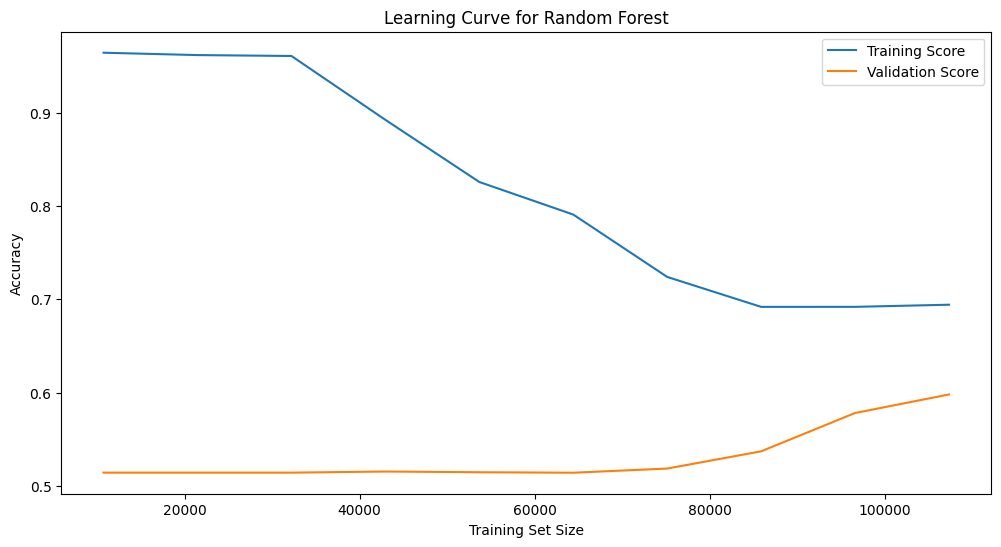

In [2]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    rf, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Validation Score")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve for Random Forest")
plt.legend()
plt.show()

Random Forest + RFE

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.feature_selection import RFE

# Load the dataset
df = pd.read_csv("C:/Yee Ann/NUS/DSA4266/TruthSeeker2023/Features_For_Traditional_ML_Techniques.csv")

# Remove unnecessary and duplicate columns
df = df.drop(columns=['Unnamed: 0'])
df = df.loc[:, df.nunique() > 1]  # Keep only columns with more than one unique value
df = df.drop_duplicates()  # Remove duplicate rows

# Convert boolean columns to integers (0 and 1)
df['majority_target'] = df['majority_target'].astype(int)

# Replace spaces in embeddings with commas and parse into lists
def replace_spaces_with_commas(emb_str):
    return emb_str.replace(' ', ',')

df['embeddings'] = df['embeddings'].apply(replace_spaces_with_commas)

# Function to extract list from string representation
def extract_list(emb_str):
    return eval(emb_str.strip("[]"))

# Apply function and create DataFrame from embeddings
embeddings_split = df['embeddings'].apply(extract_list).apply(pd.Series)
embeddings_split.columns = [f'embedding_{i}' for i in range(embeddings_split.shape[1])]

# Concatenate embeddings with the main DataFrame and drop the original embeddings column
df = pd.concat([df, embeddings_split], axis=1)
df = df.drop(['embeddings'], axis=1)

# Separate numerical and object columns, excluding the target
num_col = df.select_dtypes(['int64', 'int32', 'float64']).drop(columns=['majority_target'])
obj_col = df.select_dtypes('object')

# Drop highly correlated numerical features (correlation threshold > 0.75)
corr_matrix = num_col.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype('bool'))
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
df = df.drop(to_drop, axis=1)

# Define features (X) and target (y)
X = df.drop(['majority_target', 'statement', 'tweet', 'BinaryNumTarget'], axis=1)
y = df['majority_target']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and fit Recursive Feature Elimination with Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rfe = RFE(estimator=rf, n_features_to_select=20)
rfe.fit(X_train, y_train)

# Select the top features
selected_features = X.columns[rfe.support_]
print("Selected Features:", selected_features)

# Use only the selected features for training and testing
X_train = X_train[selected_features]
X_test = X_test[selected_features]

# Train the Random Forest model
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)
y_pred_train = rf.predict(X_train)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"RNN F1 Score: {f1:.4f}")

# Classification report
print("\nClassification Report: ")
print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))

# Confusion Matrix for test predictions
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Selected Features: Index(['followers_count', 'friends_count', 'favourites_count',
       'statuses_count', 'cred', 'normalize_influence', 'hashtags', 'URLs',
       'unique_count', 'PERSON_percentage', 'MONEY_percentage',
       'CARDINAL_percentage', 'Word count', 'Average word length',
       'past_verbs', 'adjectives', 'pronouns', 'capitals', 'digits',
       'embedding_10'],
      dtype='object')
Random Forest Accuracy: 0.6392
RNN F1 Score: 0.6393

Classification Report: 
              precision    recall  f1-score   support

        Fake       0.63      0.63      0.63     19442
        Real       0.65      0.65      0.65     20818

    accuracy                           0.64     40260
   macro avg       0.64      0.64      0.64     40260
weighted avg       0.64      0.64      0.64     40260


Confusion Matrix:
[[12268  7174]
 [ 7351 13467]]


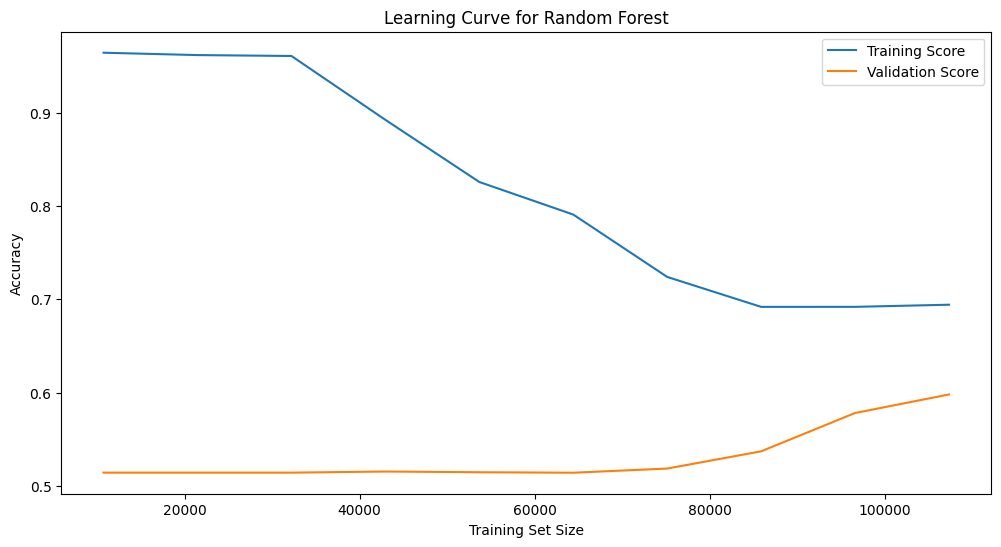

In [3]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    rf, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Validation Score")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve for Random Forest")
plt.legend()
plt.show()

Random Forest + TF-IDF

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

with open("C:/Yee Ann/NUS/DSA4266/TruthSeeker2023/Features_For_Traditional_ML_Techniques.csv") as file:
    df = pd.read_csv(file)

#remove columns with s single unique value
df = df.drop(columns = ['Unnamed: 0'])
df = df.loc[:, df.nunique() > 1]
df = df.drop_duplicates()

# Convert boolean columns to 0 and 1
df['majority_target'] = df['majority_target'].astype(int)

def replace_spaces_with_commas(emb_str):
    return emb_str.replace(' ', ',')

# Apply the function to the embeddings column
df['embeddings'] = df['embeddings'].apply(replace_spaces_with_commas)

# Function to extract the list from the string representation
def extract_list(emb_str):
    # Remove outer brackets and convert the string to a list
    return eval(emb_str.strip("[]"))

# Apply the function and create a DataFrame from the list of embeddings
embeddings_split = df['embeddings'].apply(extract_list).apply(pd.Series)

# Rename columns to reflect the split embedding positions
embeddings_split.columns = [f'embedding_{i}' for i in range(embeddings_split.shape[1])]

# Concatenate the original DataFrame with the new embeddings DataFrame
df = pd.concat([df, embeddings_split], axis=1)
df = df.drop(['embeddings'], axis=1)

#spliting the columns according to their types
num_col = df.select_dtypes(['int64', 'int32', 'float64'])
num_col = num_col.drop(columns = ['majority_target'])
obj_col = df.select_dtypes('object')

# Threshold for correlation
corr_matrix = num_col.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype('bool'))

# Drop highly correlated numerical features--anything with threshold > 0.75
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
df = df.drop(to_drop, axis=1)

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=500) 

# Fit and transform the statement and tweet columns
tweet_tfidf = tfidf_vectorizer.fit_transform(df['tweet'])

# Convert the TF-IDF matrices to DataFrames
tweet_tfidf_df = pd.DataFrame(tweet_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Now, concatenate these DataFrames with the rest of your numerical data
df = pd.concat([df, tweet_tfidf_df], axis=1)

# Now you can drop the original 'statement' and 'tweet' columns and proceed with your Random Forest model
df_processed_text = df.drop(['statement', 'tweet'], axis=1)

X = df_processed_text.drop(['majority_target', 'BinaryNumTarget'], axis=1)
y = df_processed_text['majority_target']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Define the model
rf = RandomForestClassifier(n_estimators=100, max_depth= 10, random_state=42)

# Train the Random Forest on the training data
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)
y_pred_train = rf.predict(X_train)

# Evaluate the model using accuracy
accuracy1 = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy1:.4f}")
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"RNN F1 Score: {f1:.4f}")

# Classification report
print("\nClassification Report: ")
print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))

# Confusion Matrix to understand predictions
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Random Forest Accuracy: 0.7865
RNN F1 Score: 0.7818

Classification Report: 
              precision    recall  f1-score   support

        Fake       0.88      0.64      0.74     19442
        Real       0.73      0.92      0.82     20818

    accuracy                           0.79     40260
   macro avg       0.81      0.78      0.78     40260
weighted avg       0.81      0.79      0.78     40260


Confusion Matrix:
[[12535  6907]
 [ 1689 19129]]


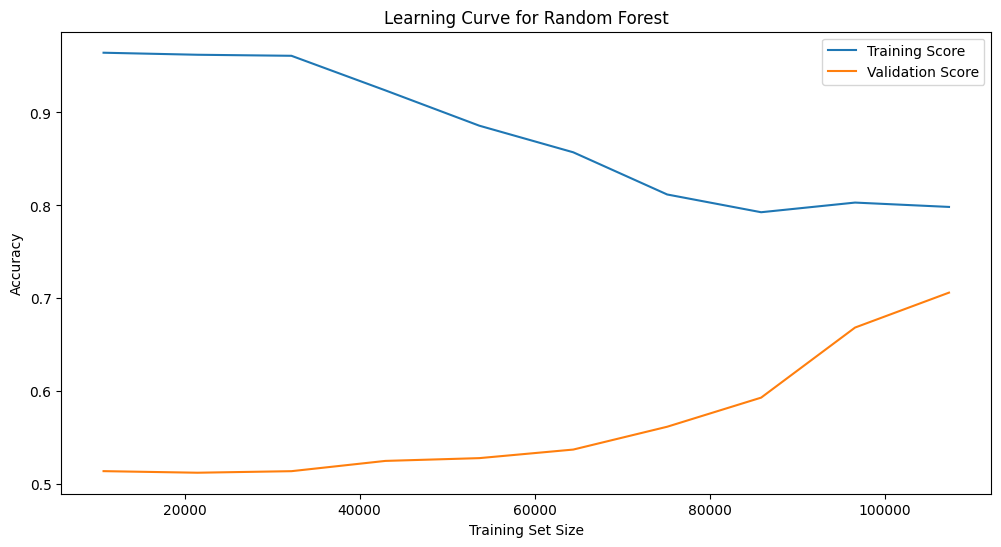

In [5]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    rf, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Validation Score")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve for Random Forest")
plt.legend()
plt.show()